In [1]:
from typing import Tuple
import random
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import xgboost as xg
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings('ignore')

from utils import generate_series, evalute_model, prepare_dataset
from data import get_dataloader
from models import Linear_ARMA, LSTM_ARMA, train_model

# Task 1. Simulating the ARMA process

### Here we generate 6 ARMA (i.e. given two models and three time intervals) processes and plot them

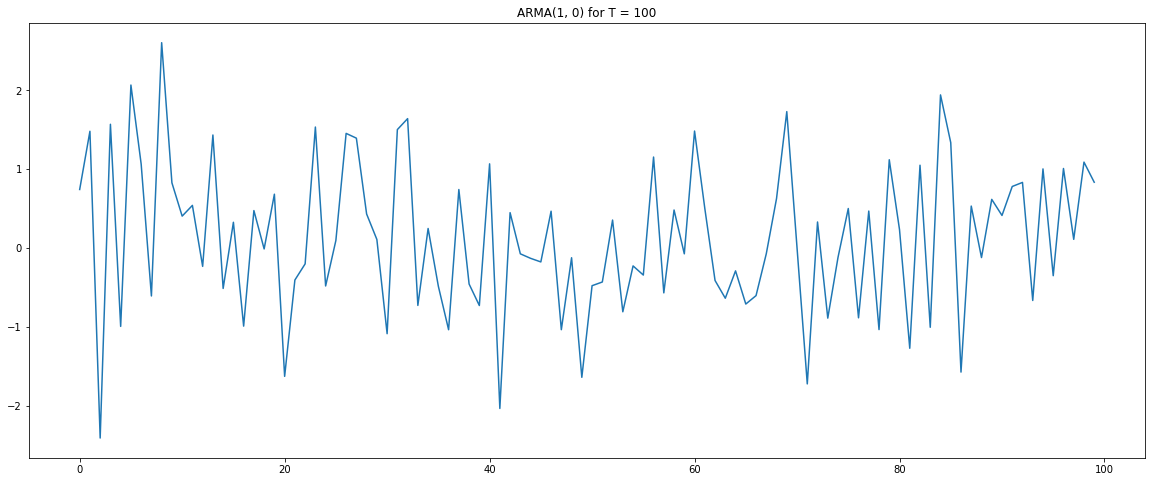

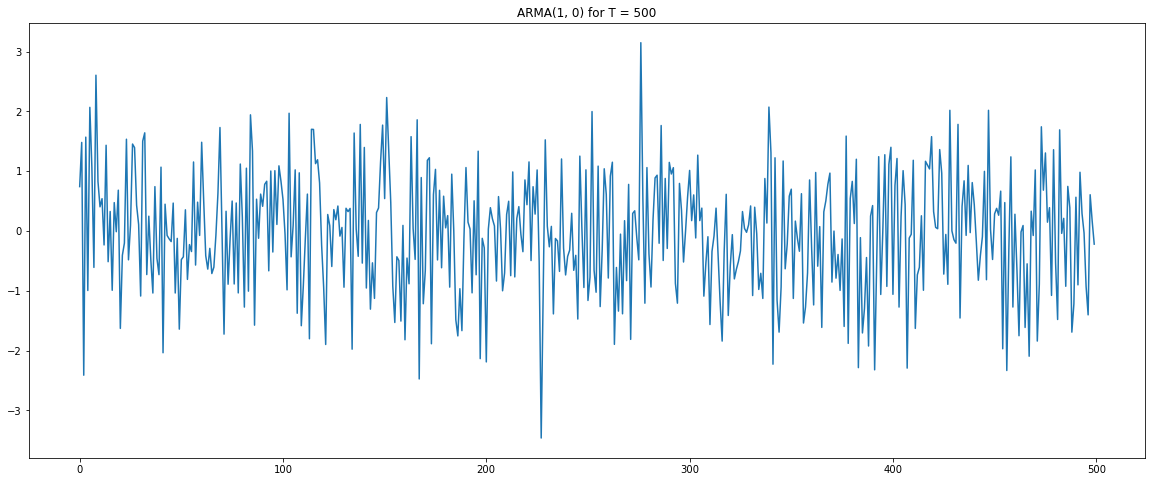

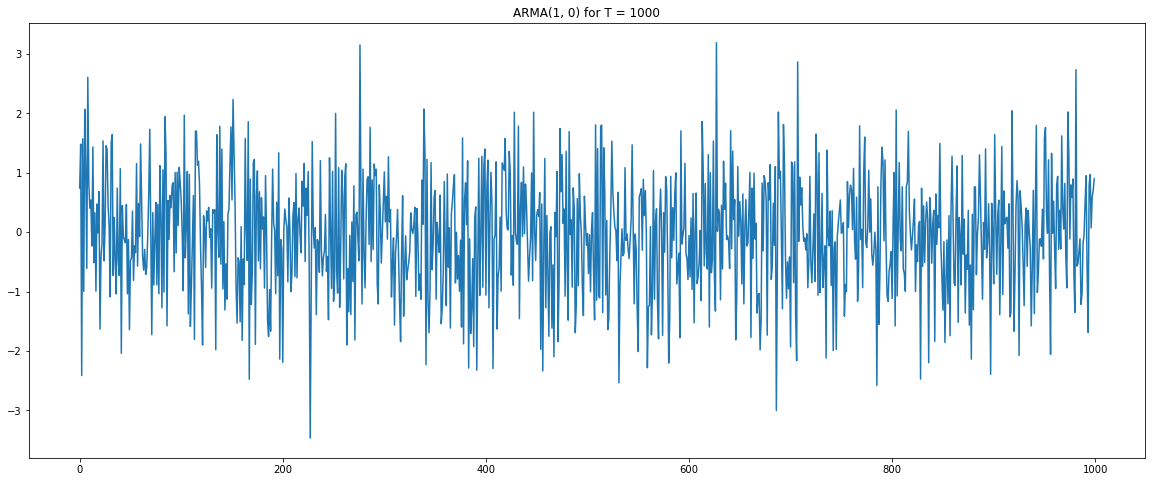

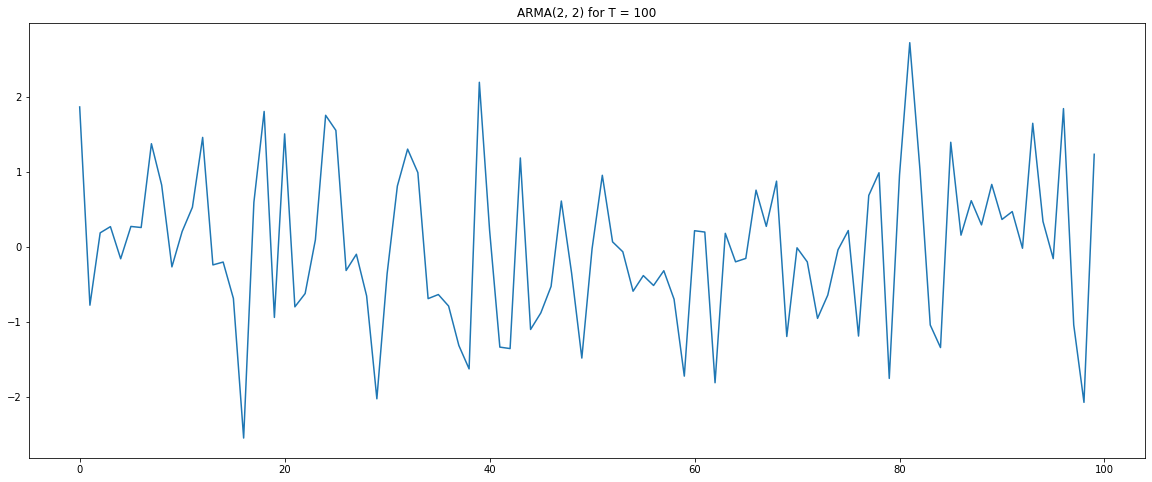

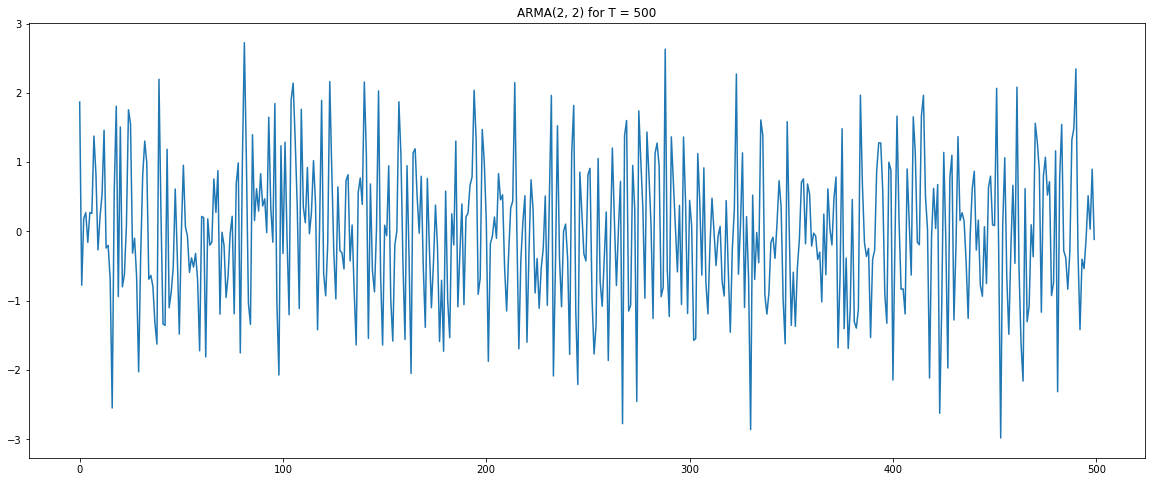

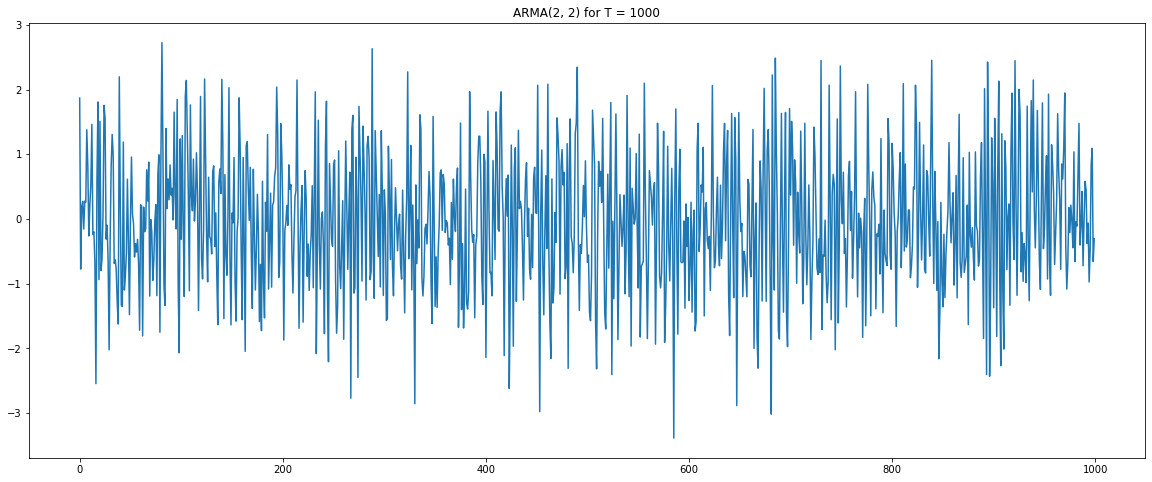

In [9]:
random.seed(14)
arma_params = [(1, 0), (2, 2)]
num_steps = [100, 500, 1000]
for params in arma_params:
    for time in num_steps:
        plt.figure(figsize=(20,8))
        model = generate_series(*params, time)[0]
        plt.title(f"ARMA{params} for T = {time}")
        plt.plot(model)

## For the remaining part of the project we will consider ARMA(2, 2) model with 500 time-steps. The model is quite complex to make the analysis more interesting. Also, I think it would be easier to interpret results of 500 time-steps.

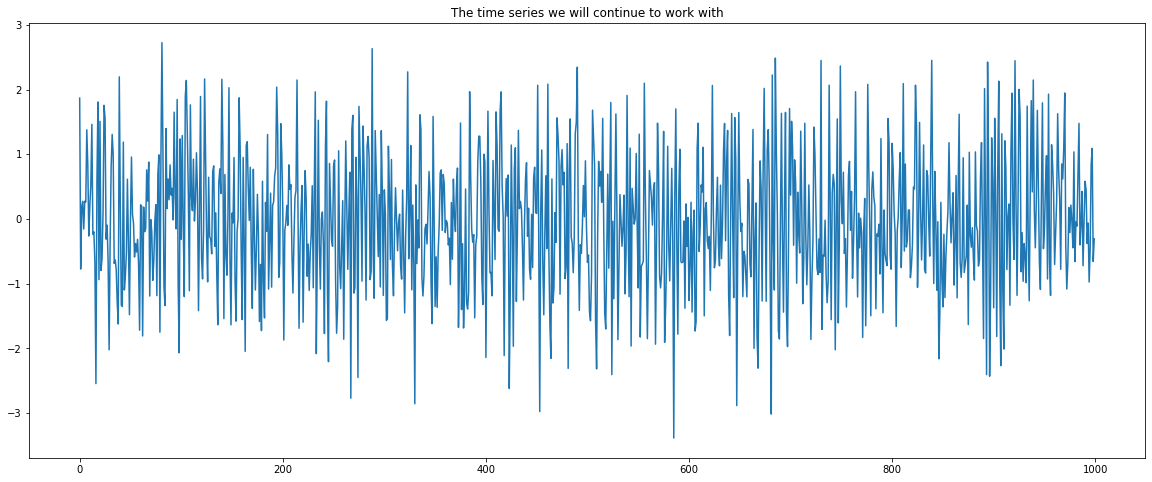

In [17]:
model = generate_series(2, 2, 1000)
plt.figure(figsize=(20,8))
plt.title(f"The time series we will continue to work with")
plt.plot(model[0]);

# Task 2. Think about

# Task 3. Fun with ML

### To evaluater models we will use Mean Absolute Error(MAE) and Root Mean Square Error(RMSE)

### Here as a baseling models we will use Linear Regression and Xgboost Regression 

For both models we need to prepare the data first. We want to feed n previous observations to be able to predict next unobseved time-stamp value. For this purpose we will create a corresponding function.

In [18]:
(X_train, y_train), (X_test, y_test) = prepare_dataset(model[0], 2)

In [19]:
lin_reg = LinearRegression().fit(X_train, y_train)
lin_reg_predictions = lin_reg.predict(X_test)

xg_reg = xg.XGBRegressor(objective ='reg:squarederror', 
                         n_estimators=20, seed = 123)
xg_reg.fit(X_train, y_train)
xg_reg_predictions = xg_reg.predict(X_test)

### We can also try to make predictions using AR and MA models

It would make sence to analyse ACF and PACF first.

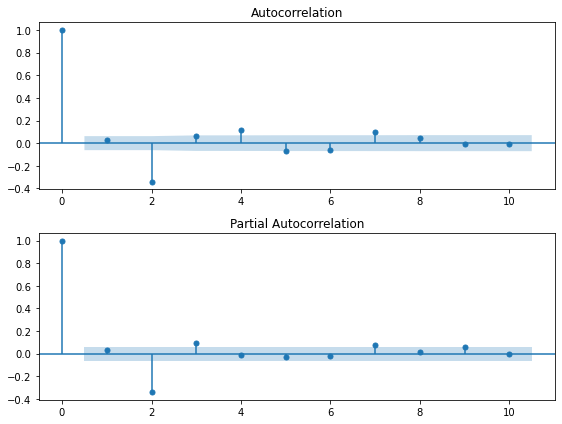

In [20]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(model[0], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(model[0], lags=10, ax=ax2)
plt.tight_layout()

Based on ACF plot we can try to predict the series using MA(7), and based on PACF we choose AR(7) model for our task.

In [21]:
def arma_predict(data: np.ndarray, test: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Train AR(7), MA(7), and ARMA(2, 2) and get predictions of test set.

    :param data: data that we use for training and prediction
    :param test: size of test dataset
    :returns:    predictions of all three models
    """
    train_size = int(len(data) * (1 - test))
    train_data, test_data = data[:train_size], data[train_size:]
    ar_predictions, ma_predictions, arma_predictions = [], [], []
    for i in tqdm(range(len(test_data)), total = len(test_data)): 
        ar_model = ARMA(train_data, order=(7,0)).fit()
        ma_model = ARMA(train_data, order=(0,7)).fit()
        arma_model = ARMA(train_data, order=(2,2)).fit()
        
        ar_predictions.append(ar_model.forecast()[0])
        ma_predictions.append(ma_model.forecast()[0])
        arma_predictions.append(arma_model.forecast()[0])
        train_data = np.append(train_data, test_data[i])
    
    return np.array(ar_predictions), np.array(ma_predictions), np.array(arma_predictions), test_data

ar_predictions, ma_predictions, arma_predictions, y_test = arma_predict(model[0])

100%|██████████| 200/200 [01:42<00:00,  1.95it/s]


## Feedforward Network

In [22]:
NUM_EPOCH = 100
EVAL_STEP = 5
PAST = 2
BATCH_SIZE = 1
LR = 1e-3

net = Linear_ARMA(PAST, 8, 1)
linear_model, linear_arma_predictions = train_model(net, LR, model[0], NUM_EPOCH, EVAL_STEP, BATCH_SIZE, PAST, 0.0)

Epoch: 5 -- MAE: 0.7580385086548074 -- RMSE: 0.9665591948056769
Epoch: 10 -- MAE: 0.7605508145151295 -- RMSE: 0.9679223038047473
Epoch: 15 -- MAE: 0.7613278725550813 -- RMSE: 0.9681997784889538
Epoch: 20 -- MAE: 0.7610285461945546 -- RMSE: 0.9681892512274772
Epoch: 25 -- MAE: 0.7631347970989342 -- RMSE: 0.9700211255289802
Epoch: 30 -- MAE: 0.7650864605419334 -- RMSE: 0.9720740631062277
Epoch: 35 -- MAE: 0.7643192283350391 -- RMSE: 0.9716867657112738
Epoch: 40 -- MAE: 0.7632624192640688 -- RMSE: 0.9711247024791974
Epoch: 45 -- MAE: 0.7632156130987036 -- RMSE: 0.9705052643566421
Epoch: 50 -- MAE: 0.7636077332420834 -- RMSE: 0.9702457357940469
Epoch: 55 -- MAE: 0.7642629817774853 -- RMSE: 0.9718100771330446
Epoch: 60 -- MAE: 0.7639394811803696 -- RMSE: 0.9699485395878101
Epoch: 65 -- MAE: 0.7647924002808155 -- RMSE: 0.97135825282262
Epoch: 70 -- MAE: 0.7635856642098743 -- RMSE: 0.968551861081162
Epoch: 75 -- MAE: 0.7631642544418877 -- RMSE: 0.9687006964569477
Epoch: 80 -- MAE: 0.764327355

## LSTM

In [23]:
NUM_EPOCH = 100
EVAL_STEP = 5

net = LSTM_ARMA(8)
lstm_model, lstm_arma_predictions = train_model(net, LR, model[0], NUM_EPOCH, EVAL_STEP, BATCH_SIZE, PAST, 0.0)

Epoch: 5 -- MAE: 0.7668442340138852 -- RMSE: 0.977609305103
Epoch: 10 -- MAE: 0.7664158969988664 -- RMSE: 0.9752539961032671
Epoch: 15 -- MAE: 0.7663999133267764 -- RMSE: 0.9730300264336866
Epoch: 20 -- MAE: 0.766049893667737 -- RMSE: 0.9716683649343082
Epoch: 25 -- MAE: 0.7663428560729612 -- RMSE: 0.9713868872959934
Epoch: 30 -- MAE: 0.7668502362466251 -- RMSE: 0.971434190627067
Epoch: 35 -- MAE: 0.7668774073851862 -- RMSE: 0.9711987375310341
Epoch: 40 -- MAE: 0.766827347611481 -- RMSE: 0.9710640523629934
Epoch: 45 -- MAE: 0.7667025183264085 -- RMSE: 0.9709216963083424
Epoch: 50 -- MAE: 0.7665668710240843 -- RMSE: 0.9708324960547192
Epoch: 55 -- MAE: 0.7666510283654212 -- RMSE: 0.9709312418844926
Epoch: 60 -- MAE: 0.7671882874947196 -- RMSE: 0.971710184970655
Epoch: 65 -- MAE: 0.7674555808365536 -- RMSE: 0.972093109834276
Epoch: 70 -- MAE: 0.767952876536492 -- RMSE: 0.9726881434414165
Epoch: 75 -- MAE: 0.7681307757803477 -- RMSE: 0.9729472725507796
Epoch: 80 -- MAE: 0.7679775813071005

## Plot the results 

In [24]:
train_size = int(len(model[0]) * 0.8)
train_data, test_data = model[0][:train_size], model[0][train_size:]
models = [lin_reg_predictions, xg_reg_predictions, ar_predictions, 
          ma_predictions, arma_predictions, linear_arma_predictions, lstm_arma_predictions]

#### Linear Regresssion

{'mae': 0.7502195243308326, 'rmse': 0.9613208973370627}


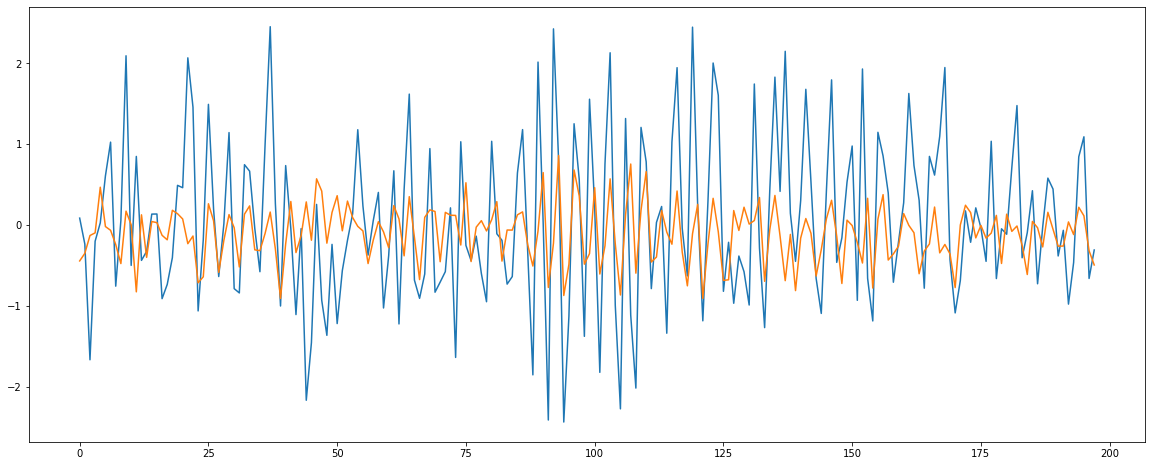

In [39]:
plt.figure(figsize=(20,8))
plt.plot(test_data[2:])
plt.plot(lin_reg_predictions)
print(evalute_model(lin_reg_predictions, test_data[2:]))

#### Xgboost Regression

{'mae': 0.8171982114127669, 'rmse': 1.0390430075314152}


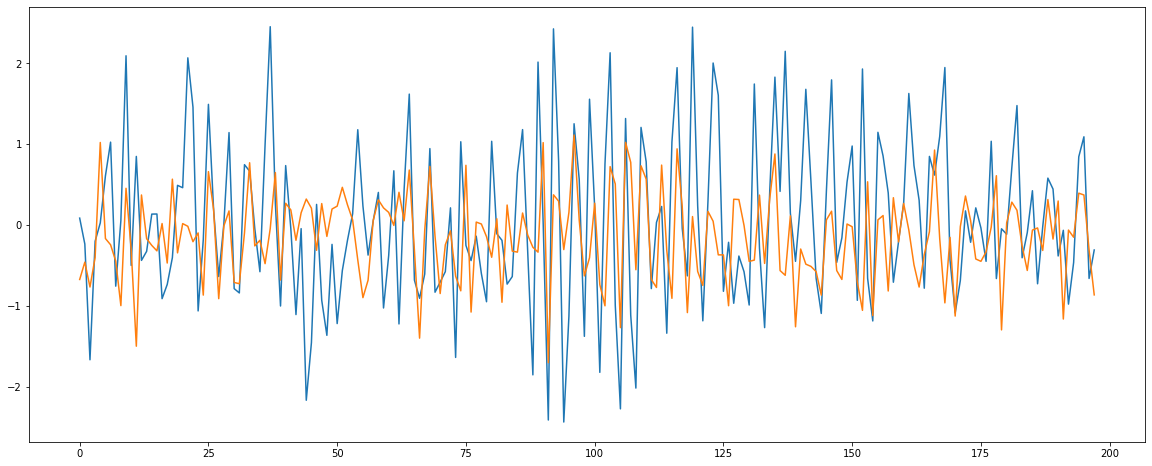

In [40]:
plt.figure(figsize=(20,8))
plt.plot(test_data[2:])
plt.plot(xg_reg_predictions)
print(evalute_model(xg_reg_predictions, test_data[2:]))

#### AR(7)

{'mae': 0.7393571323980777, 'rmse': 0.9529731894500123}


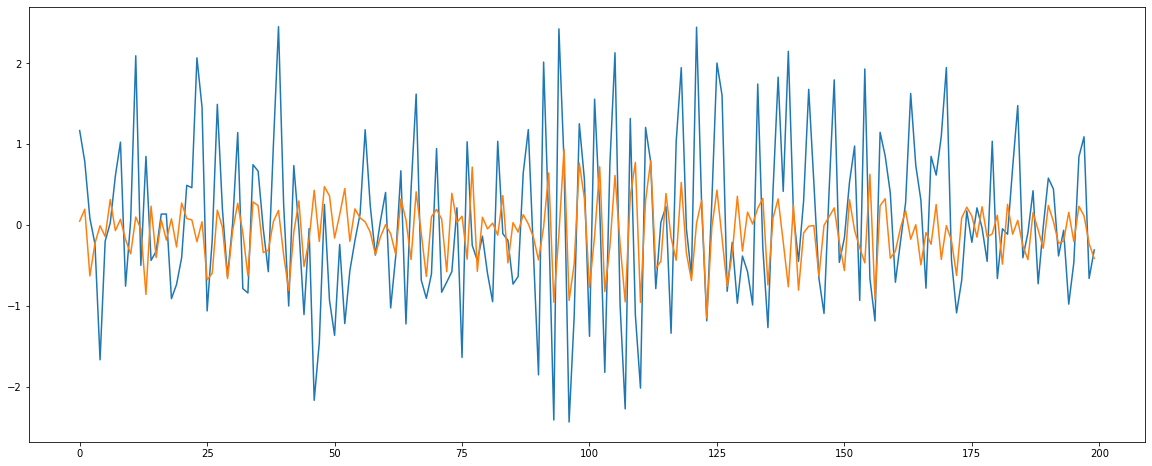

In [41]:
plt.figure(figsize=(20,8))
plt.plot(test_data)
plt.plot(ar_predictions)
print(evalute_model(ar_predictions, test_data))

#### MA(7)

{'mae': 0.7439261655947275, 'rmse': 0.9482812661539769}


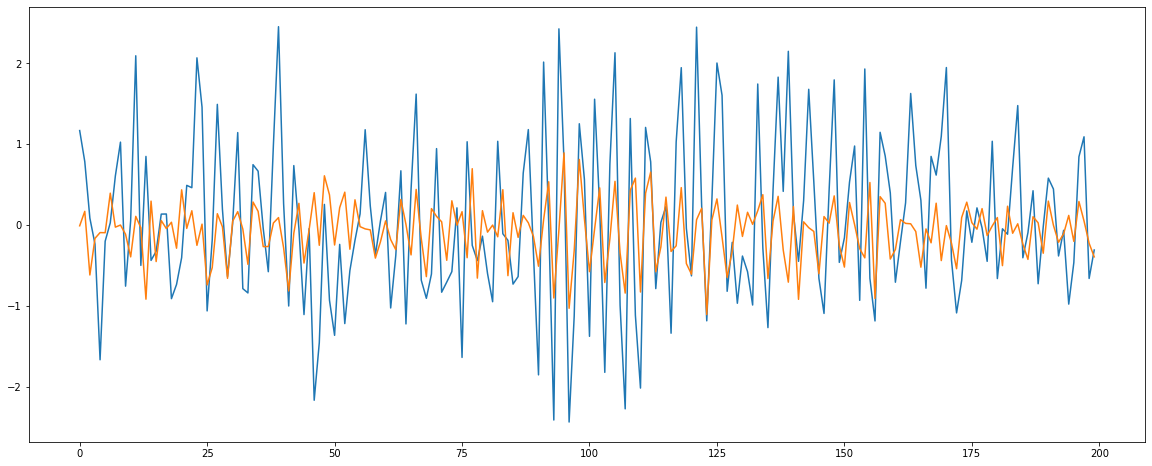

In [42]:
plt.figure(figsize=(20,8))
plt.plot(test_data)
plt.plot(ma_predictions)
print(evalute_model(ma_predictions, test_data))

#### ARMA(2, 2)

{'mae': 0.7382128944758171, 'rmse': 0.943294603019742}


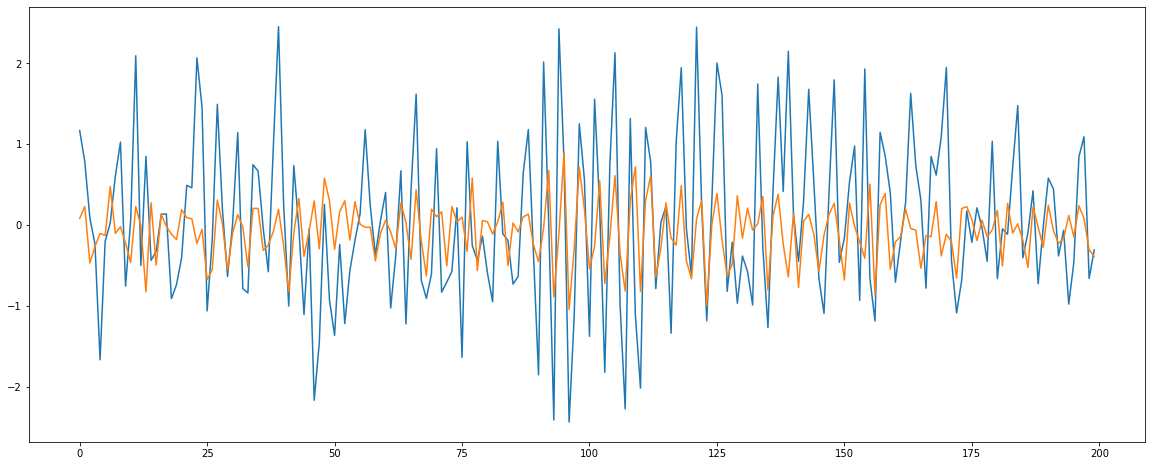

In [43]:
plt.figure(figsize=(20,8))
plt.plot(test_data)
plt.plot(arma_predictions)
print(evalute_model(arma_predictions, test_data))

#### Feedforward Network

{'mae': 0.7656588421459756, 'rmse': 0.9717640722655722}


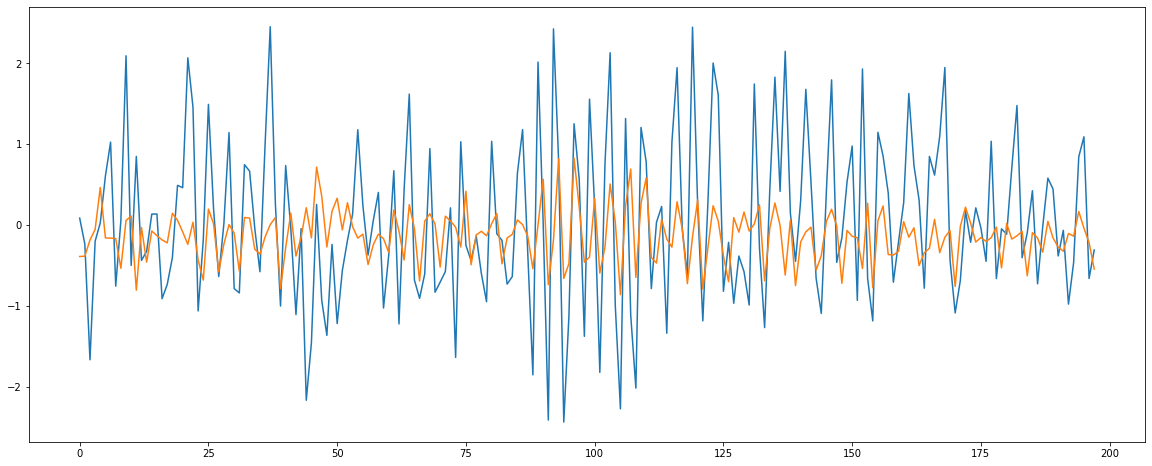

In [46]:
plt.figure(figsize=(20,8))
plt.plot(test_data[2:])
plt.plot(linear_arma_predictions)
print(evalute_model(linear_arma_predictions, test_data[2:]))

#### LSTM

{'mae': 0.7697382290122159, 'rmse': 0.9751713749762065}


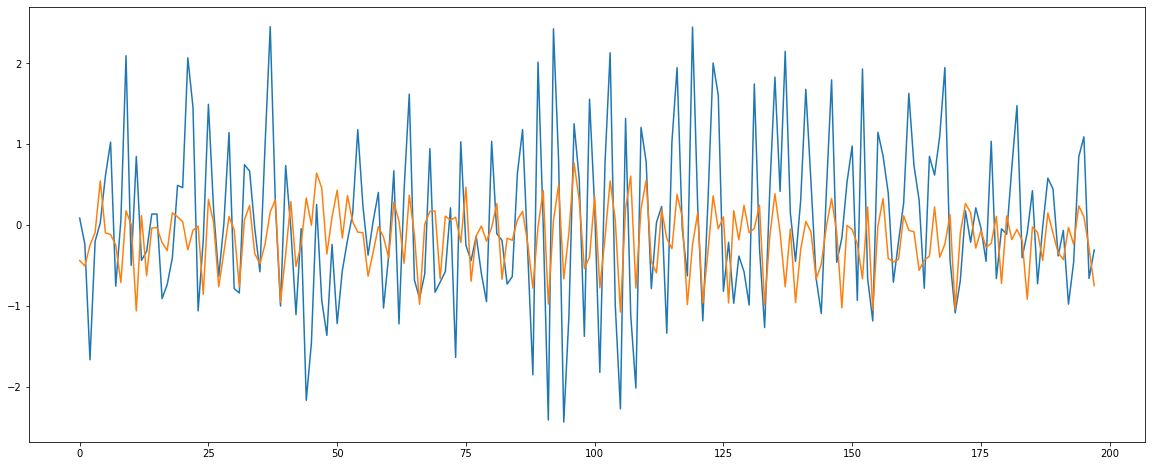

In [48]:
plt.figure(figsize=(20,8))
plt.plot(test_data[2:])
plt.plot(lstm_arma_predictions)
print(evalute_model(lstm_arma_predictions, test_data[2:]))